In [1]:
%matplotlib inline
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def draw_graph(Q, title):
    V = Q.max(axis=2)
    
    # Set up grid and test data
    nx, ny = 10, 21
    x = range(nx)
    y = range(ny)

    data = V[1:, 1:]

    hf = plt.figure(figsize=(10,10))
    ha = hf.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data.T, cmap=cm.coolwarm)
    plt.xlabel("Dealer")
    plt.ylabel("Player")
    
    labels = ['A']
    labels.extend(range(2,11))
    plt.xticks(ticks=range(1,11),labels=labels)
    
    labels.extend(range(11,22))
    plt.yticks(ticks=range(1,22), labels=labels)
    
    plt.title(title)
    plt.show()

<h2> 1 Implementation of Easy21 </h2>

You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s
0
(which may be terminal if the game is finished)
and reward r. We will be using this environment for model-free reinforcement
learning, and you should not explicitly represent the transition matrix for the
MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as
part of the environment, i.e. calling step with a stick action will play out the
dealer’s cards and return the final reward and terminal state.

In [3]:
def draw_card():
    val = random.choice(range(1,11))
    color = random.choice(['red', 'black', 'black'])
    return val * (-1) ** (color == 'red')

def check_if_finished(player, dealer):
    if dealer > 21 or player < 1:
        return 'W', 1
    if player > dealer:
        return 'W', 1
    if player < dealer:
        return 'L', -1
    if player == dealer:
        return 'D', 0
    return '0, 0'

def step(dealer, player, action):
    """
    dealer - dealer's first card 1-10
    player_sum - player's sum 1-21
    action - hit or stick
    """
    state, reward = 0, 0
    if action == 'H':
        player += draw_card()
        if player > 21 or player < 1:
             state, reward = 'L', -1
    else:
        while dealer < 17:
            dealer += draw_card()
        state, reward = check_if_finished(player, dealer)
    return player, dealer, state, reward

In [4]:
def start_of_game():
    dealer = random.choice(range(1,11))
    player = random.choice(range(1,11))
    return dealer, player

In [5]:
curr_decision = 0
dealer, player = start_of_game()
reward = 0
state = 0
inp = 0
while (state == 0) and ((inp := input()) == 'H'):
    player, dealer, state, reward = step(dealer, player, inp)
    print(player, dealer, state, reward)
if inp != 'H':
    player, dealer, state, reward = step(dealer, player, 'S')
print(player, dealer, state, reward)

H
7 1 0 0
H
17 1 0 0
S
17 21 L -1


<h2>2 Monte-Carlo Control in Easy21</h2>
Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use
a time-varying scalar step-size of $\alpha_t = \frac{1}{N(s_t, a_t)}$ and an $\epsilon$-greedy exploration
strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where $N_0 = 100$ is a constant, $N(s)$ is
the number of times that state s has been visited, and $N(s, a)$ is the number
of times that action a has been selected from state s. Feel free to choose an
alternative value for $N_0$, if it helps producing better results. Plot the optimal
value function $V^∗(s) = max_a Q^∗ (s, a)$ using similar axes to the following figure
taken from Sutton and Barto’s Blackjack example.

In [6]:
SAMPLE_NUM = 1000000

Q = np.zeros((11, 22, 2))  # matrix of values
N = np.zeros((11, 22))  # number of time state is visited
N_a = np.zeros((11, 22, 2))  # number of times action is taken from here 1-H, 2-S
N_0 = 100

In [7]:
def epsilon_greedy_exploration(N_0, dealer, player):
    epsilon = N_0 / (N_0 + N[dealer][player])
    if np.random.uniform() < epsilon:
        return random.choice(['H', 'S'])
    return ['H', 'S'][np.argmax(Q[dealer][player])]

In [8]:
for _ in tqdm(range(SAMPLE_NUM)):
    dealer, player = start_of_game()
    reward = 0
    state = 0
    inp = 0
    path = []
    
    while (state == 0) and ((inp := epsilon_greedy_exploration(N_0, dealer, player)) == 'H'):
        N[dealer][player] += 1
        N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
        path.append((dealer, player, inp))
        player, dealer, state, reward = step(dealer, player, inp)
    if inp != 'H':
        N[dealer][player] += 1
        N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
        path.append((dealer, player, inp))
        player, dealer, state, reward = step(dealer, player, 'S')
    for d, p, a in path:
        a = int(not (a == 'H'))
        Q[d][p][a] = Q[d][p][a] + 1/N_a[d][p][a]*(reward - Q[d][p][a])

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:22<00:00, 44271.75it/s]


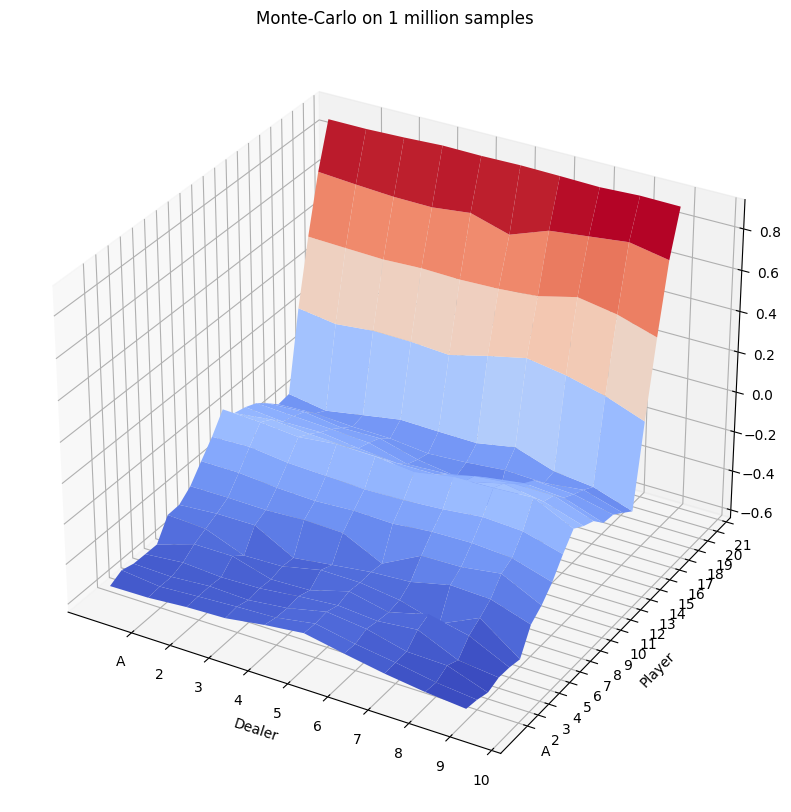

In [9]:
draw_graph(Q, 'Monte-Carlo on 1 million samples')

<h2>3 TD Learning in Easy21</h2>
Implement $Sarsa(\lambda)$ in 21s. Initialise the value function to zero. Use the same
step-size and exploration schedules as in the previous section. Run the algorithm
with parameter values $\lambda \in \{0, 0.1, 0.2, ..., 1\}$. Stop each run after 1000 episodes 
and report the mean-squared error $\sum_{s,a}(Q(s, a) − Q^∗(s, a))^2$ over all states s
and actions a, comparing the true values $Q^∗(s, a)$ computed in the previous
section with the estimated values $Q(s, a)$ computed by Sarsa. Plot the meansquared error against $\lambda$. For $\lambda$ = 0 and $\lambda$ = 1 only, plot the learning curve of
mean-squared error against episode number.


In [10]:
def sarsa(samples, l):
    SAMPLE_NUM = samples

    Q = np.zeros((11, 22, 2))  # matrix of values
    N = np.zeros((11, 22))  # number of time state is visited
    N_a = np.zeros((11, 22, 2))  # number of times action is taken from here 1-H, 2-S
    N_0 = 100
    
    def epsilon_greedy_exploration(N_0, dealer, player):
        epsilon = N_0 / (N_0 + N[dealer][player])
        if np.random.uniform() < epsilon:
            return random.choice(['H', 'S'])
        return ['H', 'S'][np.argmax(Q[dealer][player])]
    
    
    for _ in range(SAMPLE_NUM):
        dealer, player = start_of_game()
        reward = 0
        state = 0
        inp = 0
        path = []

        while (state == 0) and ((inp := epsilon_greedy_exploration(N_0, dealer, player)) == 'H'):
            N[dealer][player] += 1
            N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, inp)
        if inp != 'H':
            N[dealer][player] += 1
            N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, 'S')

            
            
        d_end, p_end, a_end = path[-1]
        a_end = int(not (a_end == 'H'))   
        for t in range(len(path)):
            G = 0
            k = 0
            for n in range(t + 1, len(path)):
                d_n, p_n, a_n = path[n]
                a_n = int(not (a_n == 'H'))
                k += (1 - l) * l ** (n - t - 1)
                G += (1 - l) * l ** (n - t - 1) * Q[d_n][p_n][a_n]
            if l == 1:
                G += l ** (len(path) - t - 1) * (reward)
            else:
                G += (1 - l) * l ** (len(path) - t - 1) * reward
            d, p, a = path[t]
            a = int(not (a == 'H'))
            Q[d][p][a] = Q[d][p][a] + 1/N_a[d][p][a]*(G - Q[d][p][a]) 
        
    return Q
    

In [11]:
errors = []
for l in np.arange(0, 1.1, 0.1):
    Q_sarsa = sarsa(1000, l)
    errors.append(((Q - Q_sarsa)**2).mean())

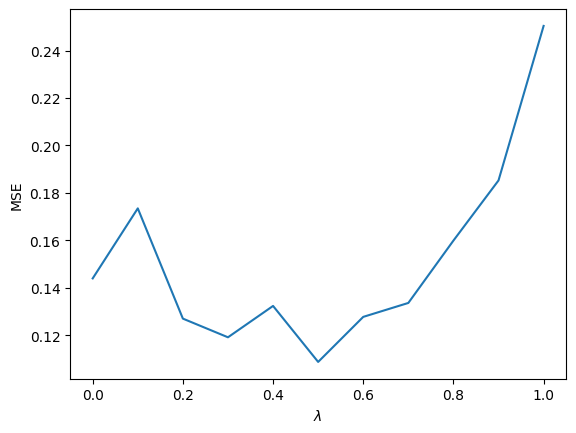

In [12]:
plt.plot(np.arange(0,1.1,0.1), errors)
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.show()

In [13]:
def sarsa_for_episodes(samples, discretization, l, Q_real):
    SAMPLE_NUM = samples
    errors = []

    Q = np.zeros((11, 22, 2))  # matrix of values
    N = np.zeros((11, 22))  # number of time state is visited
    N_a = np.zeros((11, 22, 2))  # number of times action is taken from here 1-H, 2-S
    N_0 = 100
    
    def epsilon_greedy_exploration(N_0, dealer, player):
        epsilon = N_0 / (N_0 + N[dealer][player])
        if np.random.uniform() < epsilon:
            return random.choice(['H', 'S'])
        return ['H', 'S'][np.argmax(Q[dealer][player])]
    
    
    for outer_loop in tqdm(range(SAMPLE_NUM)):
        dealer, player = start_of_game()
        reward = 0
        state = 0
        inp = 0
        path = []

        while (state == 0) and ((inp := epsilon_greedy_exploration(N_0, dealer, player)) == 'H'):
            N[dealer][player] += 1
            N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, inp)
        if inp != 'H':
            N[dealer][player] += 1
            N_a[dealer][player][int(not inp=='H')] += 1  # 'H' - 0 (False)
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, 'S')
        
        d_end, p_end, a_end = path[-1]
        a_end = int(not (a_end == 'H'))   
        for t in range(len(path)):
            G = 0
            for n in range(t + 1, len(path)):
                d_n, p_n, a_n = path[n]
                a_n = int(not (a_n == 'H'))
                G += (1 - l) * l ** (n - t - 1) * Q[d_n][p_n][a_n]
            if l == 1:
                G += l ** (len(path) - t - 1) * (reward)
            else:
                G += (1 - l) * l ** (len(path) - t - 1) * reward
            d, p, a = path[t]
            a = int(not (a == 'H'))
            Q[d][p][a] = Q[d][p][a] + 1/N_a[d][p][a]*(G - Q[d][p][a])        
        
        
        if outer_loop % discretization == 0:
            errors.append(((Q_real - Q)**2).mean())
    return Q, errors
    

In [14]:
Q_sarsa_for_0, errors_sarsa_for_0 = sarsa_for_episodes(100000, 100, 0, Q)
Q_sarsa_for_1, errors_sarsa_for_1 = sarsa_for_episodes(100000, 100, 1, Q)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 48911.40it/s]


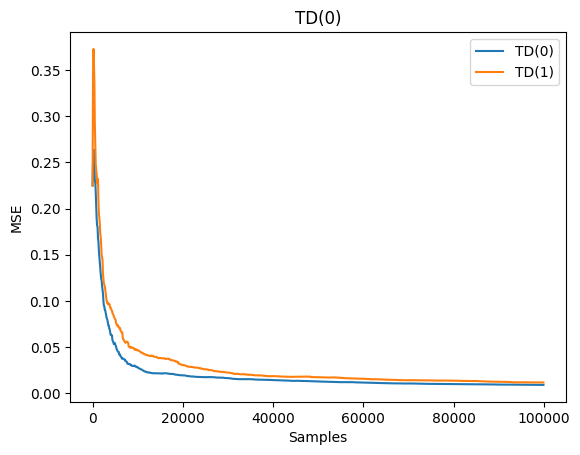

In [15]:
plt.plot(np.arange(0,100000,100), errors_sarsa_for_0, label='TD(0)')
plt.plot(np.arange(0,100000,100), errors_sarsa_for_1, label='TD(1)')
plt.title('Comparison of MSE for different $\lambda$')
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.title('TD(0)')
plt.legend()
plt.show()

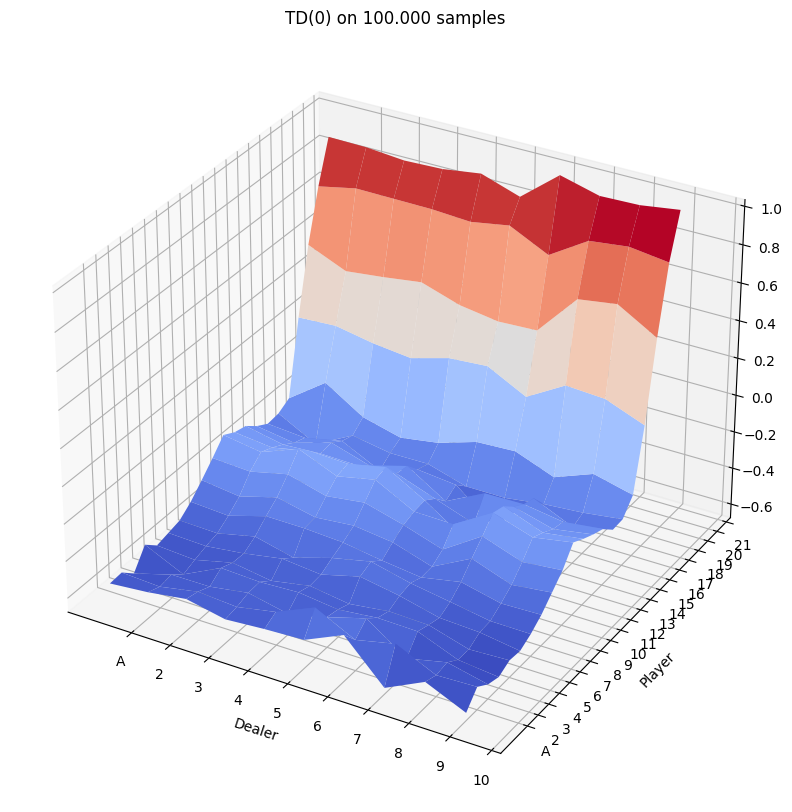

In [16]:
draw_graph(Q_sarsa_for_0, 'TD(0) on 100.000 samples')

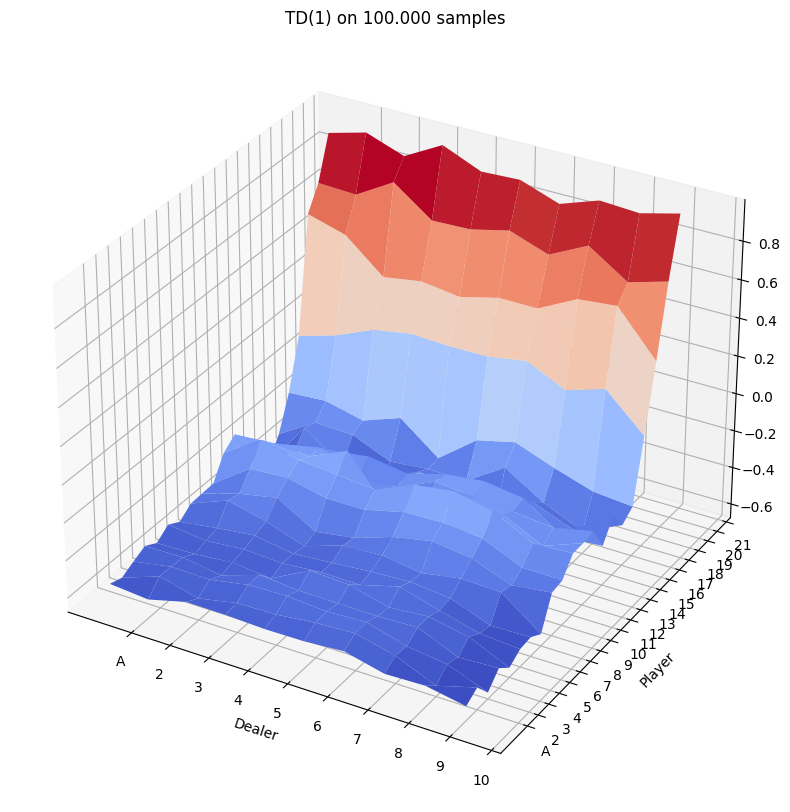

In [17]:
draw_graph(Q_sarsa_for_1, 'TD(1) on 100.000 samples')

<h2>4 Linear Function Approximation in Easy21</h2>
We now consider a simple value function approximator using coarse coding. Use
a binary feature vector φ(s, a) with 3 ∗ 6 ∗ 2 = 36 features. Each binary feature
has a value of 1 iff (s, a) lies within the cuboid of state-space corresponding to
that feature, and the action corresponding to that feature. The cuboids have
the following overlapping intervals:
$$
dealer(s) = \{[1, 4], [4, 7], [7, 10]\} \\
player(s) = \{[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]\} \\
a = \{hit, stick\}
$$
where dealer(s) is the value of the dealer’s first card (1–10); sum(s) is the sum of the player’s cards (1–21)
Repeat the $Sarsa(\lambda)$ experiment from the previous section, but using linear
value function approximation $Q(s, a) = \phi(s, a) ^ T\theta$. Use a constant exploration
of $\epsilon$ = 0.05 and a constant step-size of 0.01. Plot the mean-squared error against
$\lambda$. For $\lambda$ = 0 and $\lambda$ = 1 only, plot the learning curve of mean-squared error
against episode number.


In [18]:
def sarsa_for_linear_function_appr(samples, discretization, l, Q_real):
    SAMPLE_NUM = samples
    errors = []

    Q = np.zeros((11, 22, 2))  # matrix of values
    
    def epsilon_greedy_exploration(N_0, dealer, player):
        epsilon = 0.05
        if np.random.uniform() < epsilon:
            return random.choice(['H', 'S'])
        return ['H', 'S'][np.argmax(Q[dealer][player])]
    
    def update_with_phi(dealer, player, action, G, Q):
        n = np.array(list(range(0, 22)))
        dealer_bins = np.array([n[1:4+1], n[4: 7+1], n[7: 10+1]])
        player_bins = np.array([n[1:6+1], n[4: 9+1], n[7: 12+1], n[10: 15+1], n[13: 18+1], n[16: 21+1]])
        
        mask = np.zeros((11, 22, 2))
        mask_dealers = list(filter(lambda i: dealer in i, dealer_bins))
        mask_dealers = [item for sublist in mask_dealers for item in sublist]
        mask_players = list(filter(lambda i: player in i, player_bins))
        mask_players = [item for sublist in mask_players for item in sublist]
        dx, dy, dz = np.meshgrid(mask_dealers, mask_players, [a])
        mask[dx.flatten(), dy.flatten(), dz.flatten()] = 1
        Q = Q + mask * 0.01 * (G - Q)
        return Q
    
    for outer_loop in tqdm(range(SAMPLE_NUM)):
        dealer, player = start_of_game()
        reward = 0
        state = 0
        inp = 0
        path = []

        while (state == 0) and ((inp := epsilon_greedy_exploration(N_0, dealer, player)) == 'H'):
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, inp)
        if inp != 'H':
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, 'S')
         
        for t in range(len(path)):
            G = 0
            for n in range(t + 1, len(path)):
                d_n, p_n, a_n = path[n]
                a_n = int(not (a_n == 'H'))
                G += (1 - l) * l ** (n - t - 1) * Q[d_n][p_n][a_n]
            if l == 1:
                G += l ** (len(path) - t - 1) * (reward)
            else:
                G += (1 - l) * l ** (len(path) - t - 1) * reward
            d, p, a = path[t]
            a = int(not (a == 'H'))
            Q = update_with_phi(d, p, a, G, Q)        
        
        
        if outer_loop % discretization == 0:
            errors.append(((Q_real - Q)**2).mean())
    return Q, errors
    

In [19]:
Q_sarsa_lin_for_0, errors_for_linear_appr_0 = sarsa_for_linear_function_appr(100000, 100, 0, Q)
Q_sarsa_lin_for_1, errors_for_linear_appr_1 = sarsa_for_linear_function_appr(100000, 100, 1, Q)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4568.20it/s]


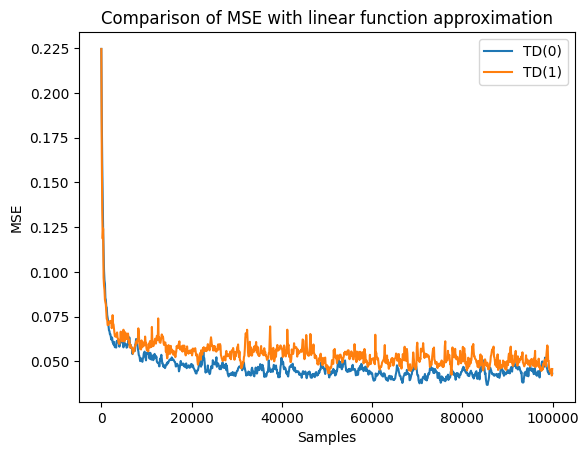

In [20]:
plt.plot(np.arange(0,100000,100), errors_for_linear_appr_0, label='TD(0)')
plt.plot(np.arange(0,100000,100), errors_for_linear_appr_1, label='TD(1)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.title('Comparison of MSE with linear function approximation')
plt.show()

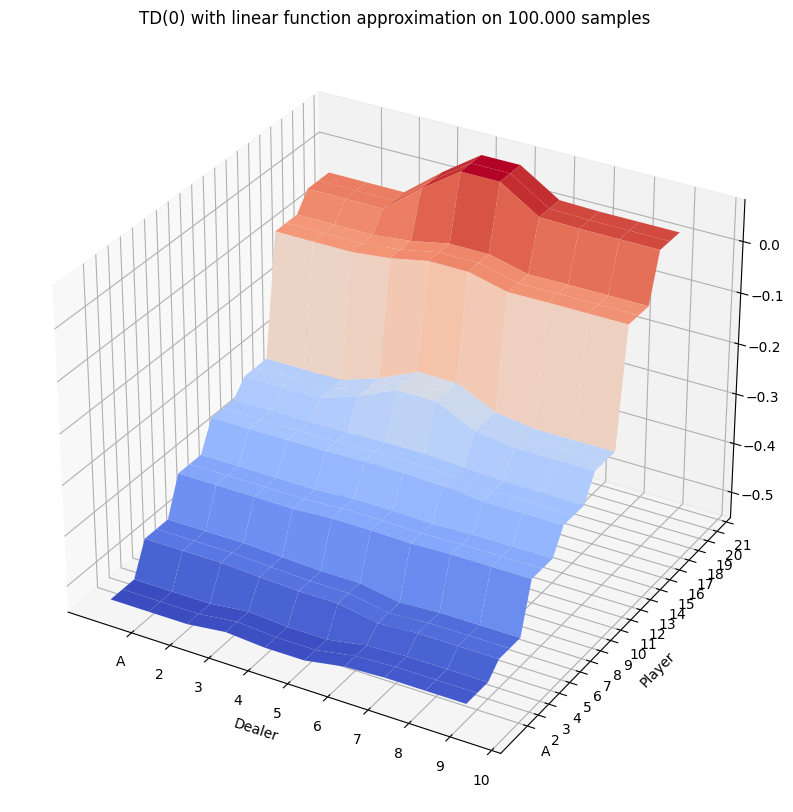

In [21]:
draw_graph(Q_sarsa_lin_for_0, 'TD(0) with linear function approximation on 100.000 samples')

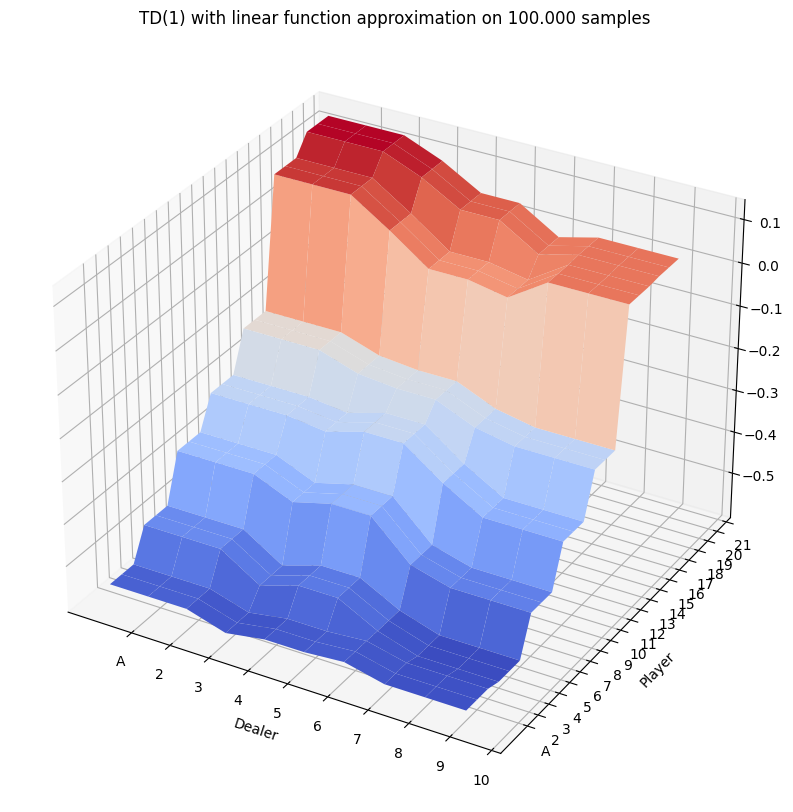

In [22]:
draw_graph(Q_sarsa_lin_for_1, 'TD(1) with linear function approximation on 100.000 samples')

Here I started to think if my function is not working because value is very low, where it had to be big. Then, I figured out that it might happen because of purly chosen bins. Intuitively, when player has low score, his value function is not chaning rapidly but previous cases showed that it rockets when player have 19-21 score. So, I decide using 'wider' bins on lower scores and 'narrower' bins on higher score. Result has become much better!

In [23]:
def sarsa_for_linear_function_appr_my_bins(samples, discretization, l, Q_real):
    SAMPLE_NUM = samples
    errors = []

    Q = np.zeros((11, 22, 2))  # matrix of values
    
    def epsilon_greedy_exploration(N_0, dealer, player):
        epsilon = 0.05
        if np.random.uniform() < epsilon:
            return random.choice(['H', 'S'])
        return ['H', 'S'][np.argmax(Q[dealer][player])]
    
    def update_with_phi(dealer, player, action, G, Q):
        n = np.array(list(range(0, 22)))
        dealer_bins = [n[1:4+1], n[4: 7+1], n[8:8+1], n[9:9+1], n[10:10+1]]
        player_bins = [n[1:6+1], n[4: 9+1], n[7: 12+1], n[10: 15+1], n[13: 17+1], n[18:18+1], n[19:19+1], n[20:20+1], n[21:21+1]]
        
        mask = np.zeros((11, 22, 2))
        mask_dealers = list(filter(lambda i: dealer in i, dealer_bins))
        mask_dealers = [item for sublist in mask_dealers for item in sublist]
        mask_players = list(filter(lambda i: player in i, player_bins))
        mask_players = [item for sublist in mask_players for item in sublist]
        dx, dy, dz = np.meshgrid(mask_dealers, mask_players, [a])
        mask[dx.flatten(), dy.flatten(), dz.flatten()] = 1
        Q = Q + mask * 0.01 * (G - Q)
        return Q
    
    for outer_loop in tqdm(range(SAMPLE_NUM)):
        dealer, player = start_of_game()
        reward = 0
        state = 0
        inp = 0
        path = []

        while (state == 0) and ((inp := epsilon_greedy_exploration(N_0, dealer, player)) == 'H'):
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, inp)
        if inp != 'H':
            path.append((dealer, player, inp))
            player, dealer, state, reward = step(dealer, player, 'S')
         
        for t in range(len(path)):
            G = 0
            for n in range(t + 1, len(path)):
                d_n, p_n, a_n = path[n]
                a_n = int(not (a_n == 'H'))
                G += (1 - l) * l ** (n - t - 1) * Q[d_n][p_n][a_n]
            if l == 1:
                G += l ** (len(path) - t - 1) * (reward)
            else:
                G += (1 - l) * l ** (len(path) - t - 1) * reward
            d, p, a = path[t]
            a = int(not (a == 'H'))
            Q = update_with_phi(d, p, a, G, Q)        
        
        
        if outer_loop % discretization == 0:
            errors.append(((Q_real - Q)**2).mean())
    return Q, errors
    

In [24]:
Q_sarsa_lin_for_0_my, errors_for_linear_appr_0_my = sarsa_for_linear_function_appr_my_bins(100000, 100, 0, Q)
Q_sarsa_lin_for_1_my, errors_for_linear_appr_1_my = sarsa_for_linear_function_appr_my_bins(100000, 100, 1, Q)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:26<00:00, 3763.81it/s]


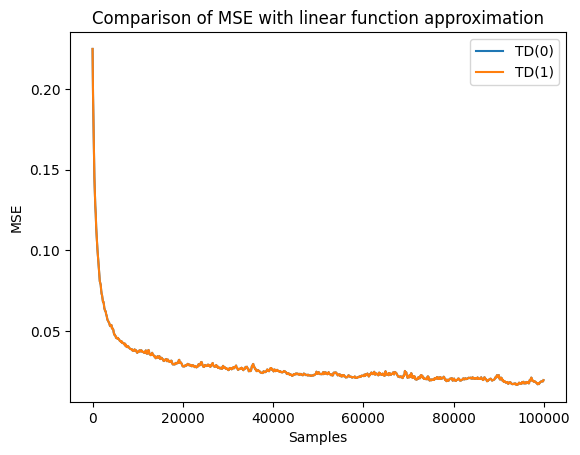

In [25]:
plt.plot(np.arange(0,100000,100), errors_for_linear_appr_0_my, label='TD(0)')
plt.plot(np.arange(0,100000,100), errors_for_linear_appr_0_my, label='TD(1)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.title('Comparison of MSE with linear function approximation')
plt.show()

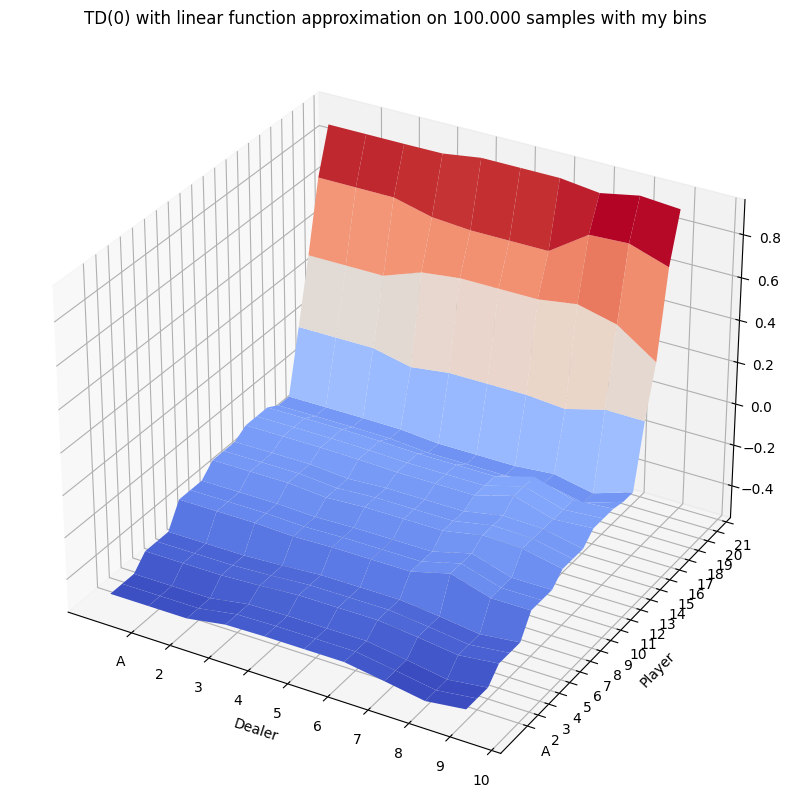

In [26]:
draw_graph(Q_sarsa_lin_for_0_my, 'TD(0) with linear function approximation on 100.000 samples with my bins')

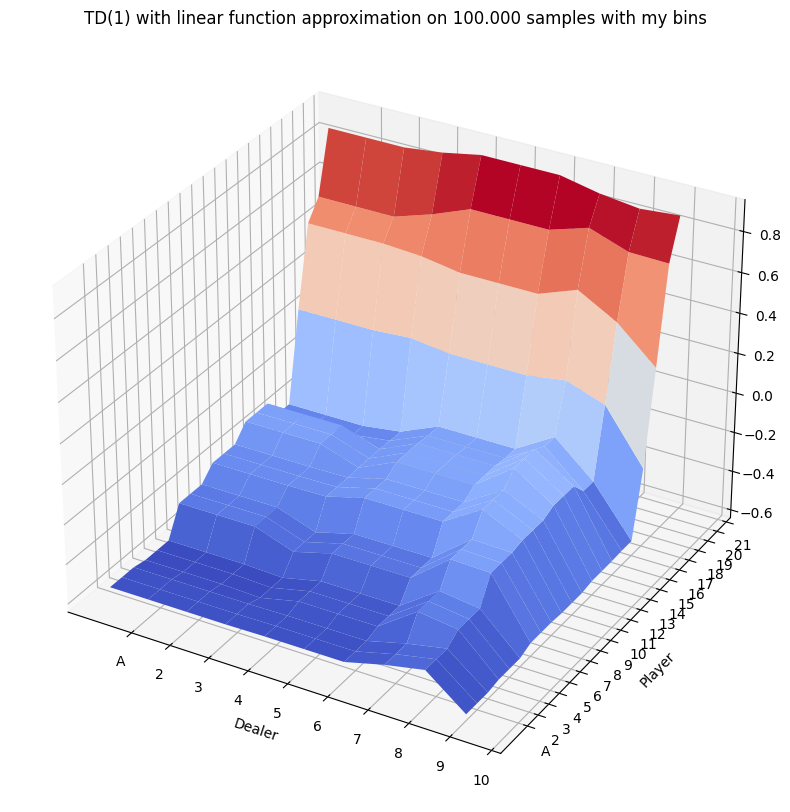

In [27]:
draw_graph(Q_sarsa_lin_for_1_my, 'TD(1) with linear function approximation on 100.000 samples with my bins')

<h2> 5 Discussion</h2>
<b>1. What are the pros and cons of bootstrapping in Easy21?</b></br>
<b>2. Would you expect bootstrapping to help more in blackjack or Easy21? Why?</b></br>
<b>3. What are the pros and cons of function approximation in Easy21?</b></br>
<b>4. How would you modify the function approximator suggested in this section to get better results in Easy21?</b>


I am really sorry but I copied answers from [here](https://github.com/kvfrans/Easy21-RL) 🙈

<b>What are the pros and cons of bootstrap?</b>

Bootstrapping has less variance, since it depends on the current reward and intermediate steps more than only the end result. However, there may be some bias, while Monte-Carlo is guaranteed to converge given enough examples.

<b>Would you expect bootstrapping to help more in blackjack or Easy21?</b>

Easy21 has red cards that can move your total sum backwards, so its episodes will last longer overall than blackjack. Therefore, bootstrapping will help more than in blackjack, where Monte-Carlo methods will work well since the episodes are short.

<b>What are the pros and cons of function approximation in Easy21?</b>

Function approximation reduces the learning time since we have less variables we need to learn. However, we lose some of the precision that was possible in a simple table lookup since the features are generalized.

<b>How would you modify the function approximator suggested in this section to get better results in Easy21?</b>

The overlapping regions led to bad results, as a certain state could trigger multiple features, and the sum of their weights could lead to values greater than one, which is impossible to achieve in the game itself. The overlapping regions should be removed, as they do not bring any significant advantage.